### jokes detection with Deep Learning

In [1]:
!pwd

/Users/tsung-chin.han/ZDOC/Berkeley/w266/NLP-Final-Project-2020/Classifier


In [2]:
import pandas as pd
import numpy as np

import json

from matplotlib import pyplot as plt
%matplotlib inline


### load reddit_jokes

In [3]:
df = pd.read_json('reddit_jokes.json')
print(df.shape)
df.head()

(194553, 4)


,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”"
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...


(array([1.93449e+05, 6.59000e+02, 2.42000e+02, 1.13000e+02, 4.90000e+01,
        2.40000e+01, 1.10000e+01, 3.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([    0. ,  4852.6,  9705.2, 14557.8, 19410.4, 24263. , 29115.6,
        33968.2, 38820.8, 43673.4, 48526. ]),
 <a list of 10 Patch objects>)

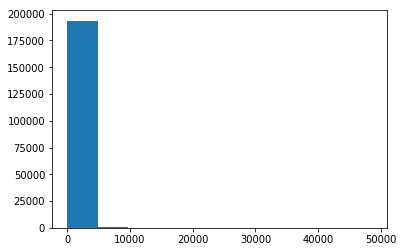

In [4]:
# orignial distributition
plt.hist(df.score)


In [5]:
# modeling score >= 10 | <10
df['is_funny'] = df.score.apply(lambda x: 1 if x >= 10 else 0)


(array([133075.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  61478.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

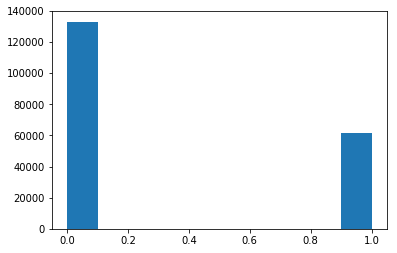

In [6]:
# modeling new binary distribution
plt.hist(df.is_funny)


In [7]:
# target
# df['target'] = 'title:' + df.title + ". " + "body:" + df.body
df['target'] = df.title + ". " + df.body


In [8]:
# finanl modeling dataset
final_modeling = df[['target', 'is_funny']]
print(final_modeling.shape)
final_modeling.head()


(194553, 2)


,target,is_funny
0,I hate how you cant even say black paint anymo...,0
1,What's the difference between a Jew in Nazi Ge...,0
2,I recently went to America..... ...and being t...,0
3,"Brian raises his hand and says, “He’s in Heave...",0
4,You hear about the University book store worke...,0


In [9]:
final_modeling.is_funny.value_counts()

0    133075
1     61478
Name: is_funny, dtype: int64

In [12]:
# import sys
# !{sys.executable} -m pip install tensorflow==1.15.0

In [10]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

1.15.0


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras import backend as K


Using TensorFlow backend.


In [12]:
max(df.target.apply(lambda x: len(x)))

39744

### preprocess data

In [13]:
texts = df.target.values

In [14]:
df.is_funny.values

array([0, 0, 0, ..., 1, 1, 0])

### (current example )

In [15]:
# Tokenizing the data
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))


Found 98403 unique tokens


In [16]:
# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.array(df.is_funny.values)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)


Shape of data tensor: (194553, 50)
Shape of labels tensor: (194553,)


In [17]:
# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


### Loading the pre-trained word embeddings
(this will be changed to GPT, but for now using glove from the example...)


In [36]:
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-03-25 22:21:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))



Found 400000 word vectors:


In [19]:
# preparing glove word embeddings matrix
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
            # for words not in embedding index values will be zeros



In [22]:
embedding_matrix.shape

(10000, 300)

In [23]:
# helper function to plot the results
def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
  
    epochs = range(1, len(acc)+1)
    
    
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, f1, label='Training f-measure')
    plt.plot(epochs, val_f1, label='Validation f-measure')
    plt.title('Training and validation f-measure')
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.legend()

    plt.show()
    

### 1 - feed-forward network with dense layers on top of embedding layer

In [24]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()


W0330 02:09:22.496881 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0330 02:09:22.499687 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0330 02:09:22.502180 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0330 02:09:22.541630 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0330 02:09:22.549224 4601718208 deprecation.py:506] From /usr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                960064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,960,129
Trainable params: 3,960,129
Non-trainable params: 0
_________________________________________________________________


In [25]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0330 02:09:25.191024 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0330 02:09:25.192096 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0330 02:09:25.192814 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0330 02:09:25.218106 4601718208 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0330 02:09:25.219052 4601718208 module_wrapper.py:139] From /usr/local/lib/py

In [26]:
# compute f-measure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [29]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.3)


# model.compile(optimizer=Adagrad(lr=0.1), loss='binary_crossentropy', metrics = ['acc', f1])
# history = model.fit(data, labels, epochs=3, batch_size=32, validation_split=0.3)



Train on 136187 samples, validate on 58366 samples
Epoch 1/20
136187/136187 [==============================] - 54s 397us/step - loss: 0.5425 - acc: 0.7325 - f1: 0.3565 - val_loss: 0.6083 - val_acc: 0.6907 - val_f1: 0.2697
Epoch 2/20
136187/136187 [==============================] - 54s 397us/step - loss: 0.5175 - acc: 0.7493 - f1: 0.4112 - val_loss: 0.6189 - val_acc: 0.6884 - val_f1: 0.2871
Epoch 3/20
136187/136187 [==============================] - 58s 426us/step - loss: 0.4902 - acc: 0.7652 - f1: 0.4622 - val_loss: 0.6332 - val_acc: 0.6881 - val_f1: 0.2891
Epoch 4/20
136187/136187 [==============================] - 57s 421us/step - loss: 0.4648 - acc: 0.7810 - f1: 0.5140 - val_loss: 0.6476 - val_acc: 0.6872 - val_f1: 0.2948
Epoch 5/20
136187/136187 [==============================] - 58s 423us/step - loss: 0.4387 - acc: 0.7949 - f1: 0.5596 - val_loss: 0.6695 - val_acc: 0.6841 - val_f1: 0.3179
Epoch 6/20
136187/136187 [==============================] - 57s 417us/step - loss: 0.4175 - ac

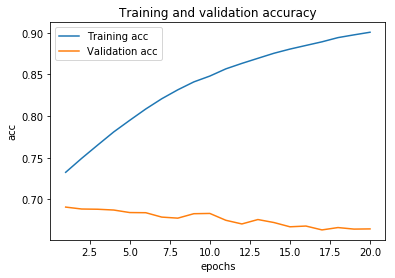

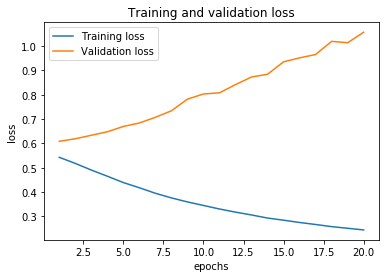

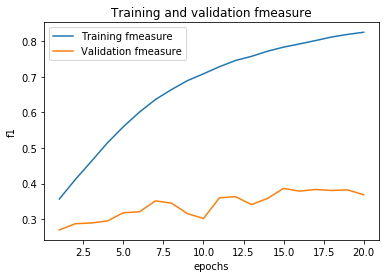

In [30]:
# plotting the results
plot_result(history)


In [ ]:
### roc 



In [198]:
# # save model
# model.save('model.h5')


In [196]:
# from keras.models import load_model

In [199]:
# model = load_model('model.h5')

### prediction

In [193]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                960064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,960,129
Trainable params: 960,129
Non-trainable params: 3,000,000
_________________________________________________________________


In [904]:
import requests
import collections


In [941]:
### helper function to make a post request

def request_jokes(url=url, question=question):
    
    while True:
        data = {'joke_title': question}
        r = requests.post(url=url, data=data)
        ans = [r.text]
        print("try 1-"+ans[0])
        if ans[0]=="Failed" or set(ans[0].split())==set(question.split()):
            r = requests.post(url=url, data=data)
            ans = [r.text]
            print("try 2-"+ans[0])
        else:
            return ans

### helper        
def request_prediction(model=model, question=question):
    
    out = []
    for i in range(len(question)):
        
        # data to be sent to api 
        ans = request_jokes(question=question[i])

        ###
        tokenizer.fit_on_texts(ans)
        token_seq = tokenizer.texts_to_sequences(ans) # text to seq
        token_seq_pad = pad_sequences(token_seq, maxlen=maxlen) # pad seq

        # process answer - after body
        if ans[0].partition(question[i])[-1][0:8] == '\n body: ':
            ans_jokes = ans[0].partition(question[i])[-1].partition('body: ')[-1]
        else:
            ans_jokes = ans[0].partition(question[i])[-1]

        # concatenate contents with title + body
        content = question[i] + " " + ans_jokes

        print(str([i])+"- jokes "+str(i+1)+": "+ content)

        # prepare results
        result = content, model.predict_classes(token_seq_pad)[0][0], model.predict_proba(token_seq_pad)[0][0]
        out.append(result)

    prediction_result = pd.DataFrame(out, columns=['jokes', 'is_funny', 'proba'])
    return prediction_result



In [944]:
question = ["""Why is it so hard to break up with a Japanese Girl? """,
            """Why did the chicken cross the road? """,
            """Why did the producers of 007 films use government debt to fund their newest film? """,
            """I feel so bad for the necrophiliac's sister. """,
            """What's the difference between you and a Calendar? """,
            """This guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time." """,
            """Roses are red. """,
            """These reports of a major snowstorm hitting the Northeast don't concern me. """,
            """Those ads actually ran. """,
            """Burnt my Hawaiian pizza today. """
           ]


In [945]:
# flask server and the question list setup
url = "http://127.0.0.1:5000/generate"

# predictions
prediction_result = request_prediction(model, question)



try 1-Why is it so hard to break up with a Japanese Girl? 

You don't have to explain that to me for two reasons:

1. You're a Japanese man and have never been with a Japanese Girl. 
2. You don't have to explain anymore. 

*Edit: Thanks so much for the feedback and to all the readers for sharing!
[0]- jokes 1: Why is it so hard to break up with a Japanese Girl?  

You don't have to explain that to me for two reasons:

1. You're a Japanese man and have never been with a Japanese Girl. 
2. You don't have to explain anymore. 

*Edit: Thanks so much for the feedback and to all the readers for sharing!
try 1-Why did the chicken cross the road? 

She said, "You know, if I'd had a dick I would've come right in here and fucked her."
[1]- jokes 2: Why did the chicken cross the road?  

She said, "You know, if I'd had a dick I would've come right in here and fucked her."
try 1-Why did the producers of 007 films use government debt to fund their newest film?  

The answer is in the title: 

"Savi

In [946]:
prediction_result


,jokes,is_funny,proba
0,Why is it so hard to break up with a Japanese ...,0,0.051966
1,Why did the chicken cross the road? \n\nShe s...,0,0.377121
2,Why did the producers of 007 films use governm...,0,0.097349
3,I feel so bad for the necrophiliac's sister. ...,0,0.001547
4,What's the difference between you and a Calend...,0,0.462920
5,This guy proposed to his wife after walking aw...,0,0.396785
6,Roses are red. \n\nThe sky is blue.\n\nPigs m...,0,0.271241
7,These reports of a major snowstorm hitting the...,0,0.028787
8,Those ads actually ran. \n\nI don't even have...,1,0.933635
9,Burnt my Hawaiian pizza today. They were gre...,0,0.151207


In [948]:
prediction_result.is_funny.value_counts()


0    9
1    1
Name: is_funny, dtype: int64

0    9
1    1
Name: is_funny, dtype: int64